In [112]:
import cv2
import numpy as np
import os 
import glob

In [139]:
def to_homogeneous(points_2d):

    return np.hstack([points_2d, np.ones((points_2d.shape[0],1))])


def compute_normalization_transform_2D(homogeneous_2D):

    centroid, scale = np.mean(homogeneous_2D[:,:2], axis = 0), np.std(homogeneous_2D[:,:2])
    scale = np.sqrt(2) / scale

    transformation = np.array([[scale,0, -(scale*centroid[0])],[0, scale, -(scale*centroid[1])], [0,0,1]])
    return transformation

def apply_K_inv(K_inv, homogenous_points):
    return np.dot(K_inv, homogenous_points.T).T

def normalize_points(transform, homogenous_points):
    return np.dot(transform, homogenous_points.T).T

def estimate_fundamental_matrix(x_prime, x):

    x_prime_homogeneous = to_homogeneous(x_prime)
    x_homogeneous       = to_homogeneous(x)

    
    transform_x_prime = compute_normalization_transform_2D(x_prime_homogeneous)
    transform_x       = compute_normalization_transform_2D(x_homogeneous)

    x_prime_camera_norm = normalize_points(transform_x_prime, x_prime_homogeneous)
    x_camera_norm = normalize_points(transform_x, x_homogeneous)
    N_points = x_prime.shape[0]
    A = np.zeros((N_points, 9))

    for p in range(N_points):
        A[p,:] = np.kron(x_prime_camera_norm[p], x_camera_norm[p])
    
    U,S,Vh = np.linalg.svd(A)
    F_norm = Vh[-1].reshape(3,3)
    Uf, Sf, Vf = np.linalg.svd(F_norm)
    Sf[-1] = 0
    F_norm_corrected = Uf @ np.diag(Sf) @ Vf
    F_norm_corrected = F_norm_corrected / F_norm_corrected[2,2]

    F = np.matmul(transform_x_prime.T, np.matmul(F_norm_corrected, transform_x))

    return F / F[2,2]    

def estimateEssentialFromFundamental(fundamental, k):

    E = np.matmul(k.T, np.matmul(fundamental,k))
    U,S,V = np.linalg.svd(E)
    E_estimated = U @ np.diag([1,1,0]) @ V

    return E_estimated / E_estimated[2,2]

def estimate_essential_matrix(x_prime, x, K):

    x_prime_homogeneous = to_homogeneous(x_prime)
    x_homogeneous       = to_homogeneous(x)

    K_inv = np.linalg.inv(K)
    x_prime_camera = apply_K_inv(K_inv, x_prime_homogeneous)
    x_camera       = apply_K_inv(K_inv, x_homogeneous)

    transform_x_prime = compute_normalization_transform_2D(x_prime_camera)
    transform_x       = compute_normalization_transform_2D(x_camera)

    x_prime_camera_norm = normalize_points(transform_x_prime, x_prime_camera)
    x_camera_norm = normalize_points(transform_x, x_camera)
    
    N_points = x_prime.shape[0]
    A = np.zeros((N_points, 9))

    for p in range(N_points):
        A[p,:] = np.kron(x_prime_camera_norm[p], x_camera_norm[p])
    
    U,S,Vh = np.linalg.svd(A)
    E_norm = Vh[-1].reshape(3,3)

    Ue, Se, Ve = np.linalg.svd(E_norm)
    Se = [1, 1, 0]

    E_norm_corrected = Ue @ np.diag(Se) @ Ve
    E_norm_corrected = E_norm_corrected / E_norm_corrected[2,2]

    E = np.matmul(transform_x_prime.T, np.matmul(E_norm_corrected, transform_x))

    return E / E[2,2]    


def decomposeEssentialMat(E):

    U,S,V = np.linalg.svd(E)

    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

    t1, t2 = U[:,2], -U[:,2]
    R1 = np.matmul(U, np.matmul(W,V))
    R2 = np.matmul(U, np.matmul(W.T, V))

    # Four possible decompositions
    rotations = []
    translations = []

    if np.linalg.det(R1) < 0:

        rotations.append(-R1)
        rotations.append(-R1)

        translations.append(-t1)
        translations.append(-t2)
    else:
        rotations.append(R1)
        rotations.append(R1)

        translations.append(t1)
        translations.append(t2)

    if np.linalg.det(R2) < 0:

        rotations.append(-R2)
        rotations.append(-R2)

        translations.append(-t1)
        translations.append(-t2)
    else:
        rotations.append(R2)
        rotations.append(R2)

        translations.append(t1)
        translations.append(t2)

    return rotations, translations

def computeProjectionMatrix(K,R,t):

    
    extrinsic = np.zeros((3,4))
    extrinsic[:,:3] = R
    extrinsic[:,3]  = t

    return np.matmul(K, extrinsic)

def skew_symmetric_matrix(vector):

    if vector.ndim == 1:

        return np.array([[0, -vector[2], vector[1]], [vector[2], 0, -vector[0]], [-vector[1], vector[0], 0]])

    skew_matrix = np.zeros((vector.shape[0], 3 ,3 ))
    skew_matrix[:,0,1] = -vector[:,2]
    skew_matrix[:,0,2] =  vector[:,1]
    skew_matrix[:,1,0] =  vector[:,2]
    skew_matrix[:,1,2] = -vector[:,0]
    skew_matrix[:,2,0] = -vector[:,1]
    skew_matrix[:,2,1] =  vector[:,0]
    
    return skew_matrix


def linearTriangulation(pts1, pts2, projection_matrix1, projection_matrix2):

    x_prime = to_homogeneous(pts1)
    x       = to_homogeneous(pts2)
    cross_prime = skew_symmetric_matrix(x_prime)
    cross_x     = skew_symmetric_matrix(x)
    
    constraint_x_prime = np.einsum("bij,jk->bik", cross_prime, projection_matrix1)
    constraint_x       = np.einsum("bij,jk->bik", cross_x, projection_matrix2)
    constraints = np.concatenate([constraint_x_prime[:,:2,:], constraint_x[:,:2,:]], axis = 1)
    U,S,V = np.linalg.svd(constraints)
    points_3d = V[:,-1] / V[:,-1,-1][...,None]
    
    return points_3d[:,:3]

def perspectiveNPoint(points_2D, points_3d):

    


In [114]:
correspondence_file = "/home/parikshat/MyWorkings/Masters/Semester_2/3d_vision/Project/Stage_1_Data_ver._2/stage1/boot/correspondences/0_2.txt"
correspondences = np.loadtxt(correspondence_file)

In [115]:
images = cv2.cvtColor(cv2.imread("/home/parikshat/MyWorkings/Masters/Semester_2/3d_vision/Project/Stage_1_Data_ver._2/stage1/boot/images/00000.jpg"), cv2.COLOR_BGR2RGB)

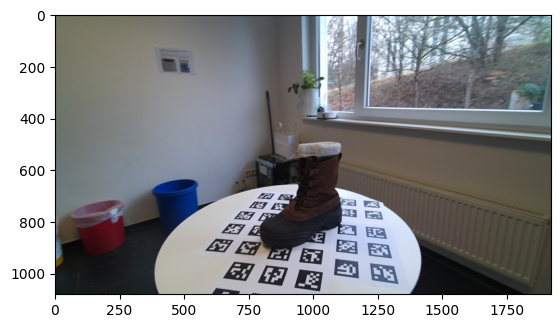

In [116]:
import matplotlib.pyplot as plt 
plt.imshow(images)

In [117]:
import json 
with open('/home/parikshat/MyWorkings/Masters/Semester_2/3d_vision/Project/Stage_1_Data_ver._2/stage1/boot/camera_parameters.json') as json_data:
    camera_parameters = json.load(json_data)
    json_data.close()
    

In [118]:
K     = np.array(camera_parameters['intrinsics'])
K_inv = np.linalg.inv(K) 

In [119]:
pts1 = np.fliplr(correspondences[:,:2])
pts2 = np.fliplr(correspondences[:,2:])

In [120]:
x_prime_homo = to_homogeneous(pts1)
x_homo       = to_homogeneous(pts2)
x_p_cam = apply_K_inv(K_inv, x_prime_homo)
x_cam   = apply_K_inv(K_inv, x_homo)
N_points = pts1.shape[0]

In [121]:
best = None
best_criterion = 0
for i in range(1000):

    points = np.random.choice(N_points,8, replace= False)
    
    f_matrix = estimateEssentialFromFundamental(estimate_fundamental_matrix(pts1[points], pts2[points]),K)
    criterion = np.sum(np.abs((x_p_cam.T * (f_matrix @ x_cam.T)).sum(axis = 0)) < 0.001)

    if criterion > best_criterion:
        best_criterion = criterion
        best = f_matrix

In [122]:
best_criterion

37

In [123]:
rotations, translations = decomposeEssentialMat(f_matrix)

In [124]:
P_prime = computeProjectionMatrix(K,np.eye(3), np.zeros((3,)))
P       = computeProjectionMatrix(K, rotations[0], translations[0])


In [125]:
cross_prime_homo = skew_symmetric_matrix(x_prime_homo)
cross_homo       = skew_symmetric_matrix(x_homo)

In [130]:
points_3d

array([[ 1.76654812, -0.9884582 , -1.98573543,  1.        ],
       [ 2.10865195, -2.06138207, -3.84990221,  1.        ],
       [ 2.02751267, -1.750632  , -3.71345623,  1.        ],
       ...,
       [ 0.81969257, -2.17253383, -3.86285616,  1.        ],
       [ 0.6616671 , -0.68471307, -0.77439846,  1.        ],
       [ 0.9349263 , -2.08185324, -6.08457714,  1.        ]])

In [131]:
image_coords = pts1.astype(np.int32)

In [132]:
colors = images[image_coords[:,0],image_coords[:,1]]

In [133]:
colors[0]

array([70, 94, 58], dtype=uint8)

In [134]:
image_coords[65]

array([ 519, 1030], dtype=int32)

In [135]:
colors[65]

array([106,  96,  95], dtype=uint8)

In [136]:
images[682,1156]

array([84, 75, 68], dtype=uint8)

In [137]:
import  struct
def write_pointcloud(filename,xyz_points,rgb_points=None):

    """ creates a .pkl file of the point clouds generated
    """

    assert xyz_points.shape[1] == 3,'Input XYZ points should be Nx3 float array'
    if rgb_points is None:
        rgb_points = np.ones(xyz_points.shape).astype(np.uint8)*255
    assert xyz_points.shape == rgb_points.shape,'Input RGB colors should be Nx3 float array and have same size as input XYZ points'

    # Write header of .ply file
    fid = open(filename,'wb')
    fid.write(bytes('ply\n', 'utf-8'))
    fid.write(bytes('format binary_little_endian 1.0\n', 'utf-8'))
    fid.write(bytes('element vertex %d\n'%xyz_points.shape[0], 'utf-8'))
    fid.write(bytes('property float x\n', 'utf-8'))
    fid.write(bytes('property float y\n', 'utf-8'))
    fid.write(bytes('property float z\n', 'utf-8'))
    fid.write(bytes('property uchar red\n', 'utf-8'))
    fid.write(bytes('property uchar green\n', 'utf-8'))
    fid.write(bytes('property uchar blue\n', 'utf-8'))
    fid.write(bytes('end_header\n', 'utf-8'))

    # Write 3D points to .ply file
    for i in range(xyz_points.shape[0]):
        fid.write(bytearray(struct.pack("fffccc",xyz_points[i,0],xyz_points[i,1],xyz_points[i,2],
                                        rgb_points[i,0].tostring(),rgb_points[i,1].tostring(),
                                        rgb_points[i,2].tostring())))
    fid.close()


In [138]:
write_pointcloud("sample.ply", points_3d[:,:3], colors)

/tmp/ipykernel_27646/1081315607.py:28: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  rgb_points[i,0].tostring(),rgb_points[i,1].tostring(),
/tmp/ipykernel_27646/1081315607.py:29: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  rgb_points[i,2].tostring())))
